In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Covid_Experiences.csv')
df

,Users,Experiences
0,User-1,"Whenever we go out, we armed ourselves with Gl..."
1,User-2,I am assuming Day 0 (say T) i.e June 10th as t...
2,User-3,I was tested positive for Covid and before I s...
3,User-4,Well it is a bit difference experience for me ...
4,User-5,I had very similar symptoms of Covid or Corona...
5,User-6,Virus can affect everyone 40+ people need to b...
6,User-7,25th October - 1st day of slight fever\n26th O...
7,User-8,Day-wise Coronavirus Symptoms:\nA day to day c...
8,User-9,Being diagnosed with the Coronavirus was more ...
9,User-10,This is a true story of one of my friend in hi...


In [ ]:
from bs4 import BeautifulSoup
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from dateutil import parser
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#Functions for NLP


def lowercase(input):
  """
  Returns lowercase text
  """
  return input.lower()

def remove_punctuation(input):
  """
  Returns text without punctuation
  """
  return input.translate(str.maketrans('','', string.punctuation))

def remove_whitespaces(input):
  """
  Returns text without extra whitespaces
  """
  return " ".join(input.split())

def remove_html_tags(input):
  """
  Returns text without HTML tags
  """
  soup = BeautifulSoup(input, "html.parser")
  stripped_input = soup.get_text(separator=" ")
  return stripped_input

def tokenize(input):
  """
  Returns tokenized version of text
  """
  return word_tokenize(input)

def remove_stop_words(input):
  """
  Returns text without stop words
  """
  input = word_tokenize(input)
  return [word for word in input if word not in stopwords.words('english')]

def lemmatize(input):
  """
  Lemmatizes input using NLTK's WordNetLemmatizer
  """
  lemmatizer=WordNetLemmatizer()
  input_str=word_tokenize(input)
  new_words = []
  for word in input_str:
    new_words.append(lemmatizer.lemmatize(word))
  return ' '.join(new_words)


def nlp_pipeline(input):
  """
  Function that calls all other functions together to perform NLP on a given text
  """
  return lemmatize(' '.join(remove_stop_words(remove_whitespaces(remove_punctuation(remove_html_tags(lowercase(input)))))))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df_final = df.drop(columns='Users')
df_final

,Experiences
0,"Whenever we go out, we armed ourselves with Gl..."
1,I am assuming Day 0 (say T) i.e June 10th as t...
2,I was tested positive for Covid and before I s...
3,Well it is a bit difference experience for me ...
4,I had very similar symptoms of Covid or Corona...
5,Virus can affect everyone 40+ people need to b...
6,25th October - 1st day of slight fever\n26th O...
7,Day-wise Coronavirus Symptoms:\nA day to day c...
8,Being diagnosed with the Coronavirus was more ...
9,This is a true story of one of my friend in hi...


In [ ]:
for index, row in df_final.iterrows():
    nlp_pipeline(row['Experiences'])

In [ ]:
df['preprocessed_review'] = df['Experiences'].apply(lambda x: nlp_pipeline(x))
df.head()

,Users,Experiences,preprocessed_review
0,User-1,"Whenever we go out, we armed ourselves with Gl...",whenever go armed glove mask sanitizers buy se...
1,User-2,I am assuming Day 0 (say T) i.e June 10th as t...,assuming day 0 say ie june 10th day covid19 sy...
2,User-3,I was tested positive for Covid and before I s...,tested positive covid share experience would l...
3,User-4,Well it is a bit difference experience for me ...,well bit difference experience compared others...
4,User-5,I had very similar symptoms of Covid or Corona...,similar symptom covid coronavirus infection al...


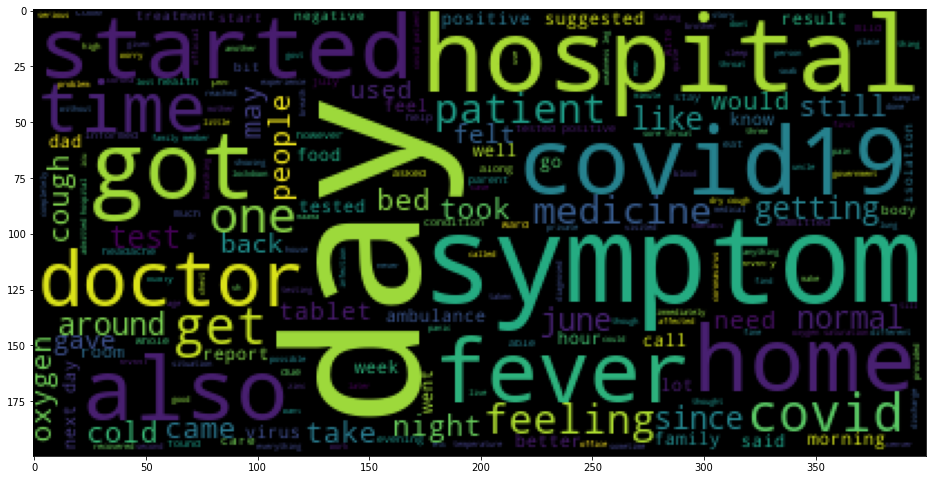

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

words_list = df['preprocessed_review'].unique().tolist()
words = " ".join(words_list)

wordcloud =  WordCloud(stopwords=stop_words).generate(words)

plt.figure(figsize=(16, 16))
plt.imshow(wordcloud)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

documents = []
for index, row in df_final.iterrows():
  documents.append(row['Experiences'])


def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([ (feature_names[i] + " (" + str(topic[i].round(2)) + ")")
          for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(str(doc_index) + ". " + documents[doc_index])

In [ ]:
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# Run NMF
nmf_model = NMF(n_components=3, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

print("NMF Topics")
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, 4, 3)
print("--------------")

pyLDAvis_data = pyLDAvis.sklearn.prepare(nmf_model, tfidf, tfidf_vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(pyLDAvis_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1425: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/p

NMF Topics
Topic 0:
day (0.26) covid (0.26) hospital (0.23) 19 (0.16)
1. I am assuming Day 0 (say T) i.e June 10th as the day when Covid-19 symptoms first started to appear. Hence days prior to Day 0 are labelled as T-1, T-2 and so on.
Day T-4 : First day of myself venturing out in Bangalore for Shopping post lockdown.
My brother and I, visited OnePlus store at Brigade Road for repairing a long pending faulty phone of his. Then we visited Decathlon to buy some casual tees. We then visited a couple of places to shop for an Ergonomic office chair since I had started to get slight back pain after continuously working from home for some months. On this day, we also had consumed tender coconuts on the streets. This was the only time we were not wearing masks, i.e while drinking coconut water.
Day T-3 : Continued WFH as usual
Day T-2 : Continued WFH as usual
Day T-1 : Continued WFH as usual though I felt a bit uneasy. Very mild cough had started by then.
Day 0 (say T) : Continued WFH as usua

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

#LDA
lda_model = LatentDirichletAllocation(n_components=3, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)
lda_W = lda_model.transform(tfidf)
lda_H = lda_model.components_

print("LDA Topics")
display_topics(lda_H, lda_W, tfidf_feature_names, documents, 2, 3)
print("--------------")


pyLDAvis_data = pyLDAvis.sklearn.prepare(lda_model, tfidf, tfidf_vectorizer)
# Visualization can be displayed in the notebook
pyLDAvis.display(pyLDAvis_data)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


LDA Topics
Topic 0:
day (1.25) 19 (1.14)
1. I am assuming Day 0 (say T) i.e June 10th as the day when Covid-19 symptoms first started to appear. Hence days prior to Day 0 are labelled as T-1, T-2 and so on.
Day T-4 : First day of myself venturing out in Bangalore for Shopping post lockdown.
My brother and I, visited OnePlus store at Brigade Road for repairing a long pending faulty phone of his. Then we visited Decathlon to buy some casual tees. We then visited a couple of places to shop for an Ergonomic office chair since I had started to get slight back pain after continuously working from home for some months. On this day, we also had consumed tender coconuts on the streets. This was the only time we were not wearing masks, i.e while drinking coconut water.
Day T-3 : Continued WFH as usual
Day T-2 : Continued WFH as usual
Day T-1 : Continued WFH as usual though I felt a bit uneasy. Very mild cough had started by then.
Day 0 (say T) : Continued WFH as usual and also visited native pla